# Importing required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Reading excel file

In [2]:
hotel = pd.read_excel('Singapore_Hotel.xlsx', comment='#')
#reading excel file, with the exception of rows commented with #
#for my installation of jupyter notebook, the excel file was located in the default folder we were instructed to direct our installation at, Documents/0_py

print('Dataset has', len(hotel), 'rows.\n')
print('Imported dataset:\n', hotel.head(3))
#checking if data set has been loaded correctly



Dataset has 580 rows.

Imported dataset:
    Year  Month  Days    Type  Occupancy Rate   Room Rate  Room Receipt
0  2020      1    31  Luxury       83.478003  506.427381    422.755465
1  2019     12    31  Luxury       86.472915  493.608149    426.837353
2  2019     11    30  Luxury       89.676464  452.747203    406.007682


# Categorical variables

In [3]:
hotel = pd.DataFrame(hotel)
hotel.head()
hotel.loc[(hotel.Days == -4383),'Days']=31
test = hotel.loc[hotel.Days == -4383,'Days']
#removing invalid data entries for Days, replacing with 31 as they all occur where Month = 1
print(test.head())
#verifying that invalid data entries for Days have been successfully removed

hotel["Year"] = hotel["Year"].astype("category")
hotel["Month"] = hotel["Month"].astype("category")
hotel["Days"] = hotel["Days"].astype("category")
hotel["Type"] = hotel["Type"].astype("category")
#setting the variables Year, Month, Days and Type as category data types, such that statsmodels can interpret them directly as categorical variables without the need for pd.get_dummies



Series([], Name: Days, dtype: int64)


# Renaming columns

In [4]:
#renaming columns to remove spaces, for compatibility with following parts
hotel.rename(columns={'Occupancy Rate': 'occupancy_rate', 'Room Rate': 'room_rate', 'Room Receipt': 'room_receipt'},inplace=True)
hotel.head()

,Year,Month,Days,Type,occupancy_rate,room_rate,room_receipt
0,2020,1,31,Luxury,83.478003,506.427381,422.755465
1,2019,12,31,Luxury,86.472915,493.608149,426.837353
2,2019,11,30,Luxury,89.676464,452.747203,406.007682
3,2019,10,31,Luxury,87.985274,457.485963,402.520279
4,2019,9,30,Luxury,88.450824,489.061425,432.578859


# Interactions

In [5]:
#code adapted from Regression_Interaction_Variable (- Collinearity).ipynb, collinearity component has been commented out as we are addressing that subsequently.
df = hotel
y = 'room_receipt'

pd.options.mode.chained_assignment = None
colname = list(df)
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]
print(df.head())

trf = ['_cube', '_cbrt']

import numpy as np

for i in list(df)[1:]:
    try:
        df[i + trf[0]] = df[i] ** (3. if '_cube' in trf else 2.)
        df[i + trf[1]] = np.cbrt(df[i]) if '_cube' in trf else np.sqrt(df[i])
    except:
        df.drop(i, axis=1, inplace=True)

df0 = df.copy()
    
#perform feature selection using adjusted R2

modeleq = ' + '.join(list(df)).replace('+', '~', 1)
print('\n',modeleq)
maxR2 = -np.inf
bmodeleq = modeleq
numx = df.shape[1] - 1
x1x2 = False #interaction variables not yet included

from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs) found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df0[colname]
            colname = colname[1:] #remove y
            
            for i in range(numx):
                #look for 1st transformed variable:
                if colname[i][-5:] in trf:
                    i = i - 1
                    #colname[i] is the last untransformed x
                    break
            
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  'untransformed variables in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = colname[j] + '_x_' + colname[k]
                    print(a)
                    df[a] = df[colname[j]] * df[colname[k]]
                    
            df0 = df.copy()
                    
            #delete any x too highly correlated with another x, to avoid collinearity
            
            corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
            for x in list(df)[1:]:
                #during 1st time thru loop, new column, with label, created in empty dataframe
                corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe
                
            corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked
            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            x1x2 = True #interaction variables already included
            
            #beyond-pairwise collinearity may still be introduced with the interaction variables
            
            df = df0.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

print('\nBest model has', bmodeleq.count('+') + 1, 'Xs:')
out = ols(bmodeleq, df0).fit()
#collinearity is still entirely possible at this stage
print(out.summary2())

print("\nDescending order of X's significance:")
print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
#if the single best variable isn't high in above ranking, collinearity might be an issue


   room_receipt  Year Month Days    Type  occupancy_rate   room_rate
0    422.755465  2020     1   31  Luxury       83.478003  506.427381
1    426.837353  2019    12   31  Luxury       86.472915  493.608149
2    406.007682  2019    11   30  Luxury       89.676464  452.747203
3    402.520279  2019    10   31  Luxury       87.985274  457.485963
4    432.578859  2019     9   30  Luxury       88.450824  489.061425

 room_receipt ~ occupancy_rate + room_rate + occupancy_rate_cube + occupancy_rate_cbrt + room_rate_cube + room_rate_cbrt

Adjusted R2 = 0.9964955622262521 for 6 Xs.
Variable to drop: room_rate_cube

Adjusted R2 = 0.9964817520165847 for 5 Xs.
Variable to drop: occupancy_rate_cube

Adjusted R2 = 0.9964526880003438 for 4 Xs.
Variable to drop: occupancy_rate_cbrt

Adjusted R2 = 0.9962339538401873 for 3 Xs.
Variable to drop: room_rate_cbrt

Adjusted R2 = 0.9957001529524155 for 2 Xs.
Variable to drop: occupancy_rate

Adjusted R2 = 0.9815747087177957 for 1 Xs.
Variable left: room_rate


Notably, when we run the code for interactions and find the least squares regression for all variables including the interactions, we find that the interaction occupancy_rate x room_rate seems to be highly significant, with a close to infinite t-value and a P-value of virtually 0. Upon a closer look at the data in Excel, we find that the room receipt column is calculated by multiplying the occupancy rate by the room rate.

Keeping in mind that room receipt is processed data, I have opted to conduct an analysis where the room rate, instead of room receipt, is the dependent variable. I felt that it would be counter-intuitive to attempt to train a model to predict room receipt using all other data, when it can be perfectly calcualted just by multiplying the room rate by the occupancy rate.

# Interactions with room rate as Y

In [6]:
#interaction again but this time with y = room_rate
df = hotel
y = 'room_rate'

pd.options.mode.chained_assignment = None  # default='warn'
#get column names:
colname = list(df)
#move y to position 0:
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]
print(df.head())

#transform all Xs into cube & cube-root, using np.cbrt()

trf = ['_cube', '_cbrt'] #may be adapted for square & square-root

import numpy as np

for i in list(df)[1:]:
    try:
        df[i + trf[0]] = df[i] ** (3. if '_cube' in trf else 2.)
        df[i + trf[1]] = np.cbrt(df[i]) if '_cube' in trf else np.sqrt(df[i])
    except:
        #column cannot be transformed
        #delete non-numeric column (with no questions asked!):
        df.drop(i, axis=1, inplace=True)

#only numeric columns left
df0 = df.copy() #kept for inclusion of interaction variables later
    
#perform feature selection using adjusted R2

modeleq = ' + '.join(list(df)).replace('+', '~', 1)
print('\n',modeleq)
maxR2 = -np.inf
bmodeleq = modeleq
numx = df.shape[1] - 1
x1x2 = False #interaction variables not yet included

from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq
#     if R2 == 0:
#         break

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs) found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df0[colname]
            colname = colname[1:] #remove y
            
            for i in range(numx):
                #look for 1st transformed variable:
                if colname[i][-5:] in trf:
                    i = i - 1
                    #colname[i] is the last untransformed x
                    break
            
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  'untransformed variables in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = colname[j] + '_x_' + colname[k]
                    print(a)
                    df[a] = df[colname[j]] * df[colname[k]]
                    
            df0 = df.copy()
                    
            #delete any x too highly correlated with another x, to avoid collinearity
            
            corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
            for x in list(df)[1:]:
                #during 1st time thru loop, new column, with label, created in empty dataframe
                corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe
                
            corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked
            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            x1x2 = True #interaction variables already included
            
            #beyond-pairwise collinearity may still be introduced with the interaction variables
            
            df = df0.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

print('\nBest model has', bmodeleq.count('+') + 1, 'Xs:')
out = ols(bmodeleq, df0).fit()
#collinearity is still entirely possible at this stage
print(out.summary2())

print("\nDescending order of X's significance:")
print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
#if the single best variable isn't high in above ranking, collinearity might be an issue

    room_rate  Year Month Days    Type  occupancy_rate  room_receipt
0  506.427381  2020     1   31  Luxury       83.478003    422.755465
1  493.608149  2019    12   31  Luxury       86.472915    426.837353
2  452.747203  2019    11   30  Luxury       89.676464    406.007682
3  457.485963  2019    10   31  Luxury       87.985274    402.520279
4  489.061425  2019     9   30  Luxury       88.450824    432.578859

 room_rate ~ occupancy_rate + room_receipt + occupancy_rate_cube + occupancy_rate_cbrt + room_receipt_cube + room_receipt_cbrt

Adjusted R2 = 0.9970989996547504 for 6 Xs.
Variable to drop: room_receipt_cube

Adjusted R2 = 0.9970994018079757 for 5 Xs.
Variable to drop: occupancy_rate_cube

Adjusted R2 = 0.9970721669327363 for 4 Xs.
Variable to drop: occupancy_rate_cbrt

Adjusted R2 = 0.9969226649829774 for 3 Xs.
Variable to drop: room_receipt_cbrt

Adjusted R2 = 0.9954352780371597 for 2 Xs.
Variable to drop: occupancy_rate

Adjusted R2 = 0.9815747087177957 for 1 Xs.
Variable left

With our findings from the previous run of the interaction test in mind, I decided to run the code again with our new y variable set as the room rate.

This time, we find that the transformed variables occupancy_rate_cube and occupancy_rate_cbrt were identified along with the interaction variable occupancy_rate_x_room_receipt.

# Collinearity

In [7]:
#code has been modified from Regression_ Collinearity .ipynb to use output from previous step (Interactions) as input for this step
#delete non-numeric columns:
df = df0.select_dtypes(['number'])

#get column names:
colname = list(df0)
#move y to position 0:
colname.insert(0, colname.pop(colname.index(y)))
df = df[colname]

df0 = df.copy()

#delete any x too highly correlated with another x, to avoid collinearity

corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
for x in list(df)[1:]:
    #during 1st time thru loop, new column, with label, created in empty dataframe
    corv.loc[x, y] = df[x].corr(df[y]) #new entry, with row label, added to dataframe

corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked

delta = 0.005 #corr difference lower limit
dl2 = []
icorr = True
while icorr:
    a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
    colname = list(df)[1:]
    dl = []
    print('\nX pairs with correlations >', 1 - delta, ':')
    for b in range(1, a.shape[0]):
        if a.iloc[b, 0]:
            if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                #deleting 1 X from correlated pair:
                dv0 = a.index[b - 1]
                dv1 = a.index[b]

                #neither should already be deleted:
                if not (dv0 in dl) and not (dv1 in dl):
                    #delete x with rather lower corr(x, y):
                    if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                        d = dv1
                    elif len(dv0) < len(dv1): #delete x with longer name:
                        d = dv1
                    else:
                        d = dv0

                    dl.append(d) #for en masse deletion later
                    corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                    print(dv0,',',dv1)

    if len(dl) > 0:
        df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
        dl2 = dl2 + dl #keep for real deletion later
        print('\n' + str(len(dl)), 'variables considered for deletion:')
        print('\n'.join([str(x) for x in dl]))
    else:
        print('(no more)')
        icorr = False

#remaining Xs may be collinear
print('\n' + str(len(dl2)), 'collinear variables deleted.')

#potential collinearity issues handled

df0 = df.copy() #kept for inclusion of interaction variables later
#df = df0
    
#perform feature selection using adjusted R2

modeleq = ' + '.join(list(df)).replace('+', '~', 1)
#print(modeleq)

import numpy as np
maxR2 = -np.inf
bmodeleq = bmodeleq
numx = df.shape[1] - 1

from statsmodels.formula.api import ols

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    #see if a better model is found:
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        #one xvar left
        #get out of 'while' loop:
        break
            
    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

print('\nBest model has', bmodeleq.count('+') + 1, 'Xs:')
out = ols(bmodeleq, df0).fit()
#collinearity is still entirely possible at this stage
print(out.summary2())

print("\nDescending order of X's significance:")
print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
#if the single best variable isn't high in above ranking, collinearity might be an issue
print(df0.head())


X pairs with correlations > 0.995 :
occupancy_rate_cbrt , occupancy_rate

1 variables considered for deletion:
occupancy_rate_cbrt

X pairs with correlations > 0.995 :
(no more)

1 collinear variables deleted.

Adjusted R2 = 0.9999443223560164 for 5 Xs.
Variable to drop: room_receipt_cbrt

Adjusted R2 = 0.9999444106597666 for 4 Xs.
Variable to drop: occupancy_rate_cube

Adjusted R2 = 0.999797170037338 for 3 Xs.
Variable to drop: occupancy_rate

Adjusted R2 = 0.9997769316904033 for 2 Xs.
Variable to drop: occupancy_rate_x_room_receipt

Adjusted R2 = 0.9815747087177957 for 1 Xs.
Variable left: room_receipt

Best model has 4 Xs:
                         Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          1.000    
Dependent Variable:       room_rate             AIC:                     1547.9132
Date:                     2021-02-16 22:42      BIC:                     1569.7283
No. Observations:         580                   Log-Likelih

The above test found that the transformed variable occupancy_rate_cbrt and occupancy_rate have a high correlation of greater than 0.995, thus occupancy_rate_cbrt is deleted and occupancy_rate is kept instead. Other than this, there were no collinear variables with correlation beyond the threshold of 0.995.

# Pulling values for X and y, splitting for train and test

In [8]:
category_df = hotel.select_dtypes(include=['category']).copy()
#selecting only columns of the categorical type from our original dataframe
df1 = pd.concat([df0,category_df], axis=1)
#adding back categorical data into the output dataframe of our Interaction and Collinearity sections, since categorical data was dropped earlier in Interactions

y = df1[['room_rate']]
X = df1[['occupancy_rate','room_receipt','occupancy_rate_cube','occupancy_rate_x_room_receipt','Year','Month','Days','Type']]
#splitting our combined dataframe into our dependent variable room rate, with all other variables as independent variables

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=1)
#splitting data into test and train

datatrain = pd.concat([Xtr,ytr],axis=1)
#concatenate X train and y train into one dataframe, as statsmodels' OLS implementation takes one dataframe and one modeleq as input rather than two dataframes like scikit-learn (X and y)
datatrain.head()

,occupancy_rate,room_receipt,occupancy_rate_cube,occupancy_rate_x_room_receipt,Year,Month,Days,Type,room_rate
133,67.473473,241.990349,307184.427507,16327.929269,2008,12,31,Luxury,358.645165
552,80.246025,74.229698,516738.228907,5956.638251,2010,4,30,Economy,92.502648
429,83.199729,171.070725,575924.738253,14233.037971,2008,6,30,Mid-Tier,205.614523
323,84.801020,142.322849,609822.193655,12069.122776,2017,4,30,Mid-Tier,167.831530
255,88.662429,225.627484,696977.697617,20004.680895,2010,11,30,Upscale,254.479249


# Variable selection

In [9]:
#modified frorm Regression_Feature_Selection.ipynb to return hout and store hout such that it is stored as a global variable and called be called upon in the following segments
import warnings
warnings.filterwarnings('ignore')  #suppress warning messages (those with peach background)

def mr(selection=False):
    h = datatrain #use 1st column as row labels
    #print(h.head(0)) # dataset's variable names
    print('\nThe dataset has', len(h), 'rows and', h.shape[1], 'columns.', '' if selection else '\n')

    
    yvar = 'room_rate'
    modeleq = yvar + ' ~'
    for xvar in (  # insert new 'x variable' into a row, ending with ','
            'Year',
            'Month',
            'Days',
            'Type',
            'occupancy_rate',
            'room_receipt',
            'occupancy_rate_cube',
            'occupancy_rate_x_room_receipt'
            ):
        if modeleq[-1] == '~':
            modeleq = modeleq + ' ' + xvar
        else:
            modeleq = modeleq + ' + ' + xvar

    bmodeleq = modeleq
    
    if selection:
        #eliminate X variables one by one:
        print('\nVariable Selection using t-stat p-value & PR(>F):')
        
        #initialize p-value & adjusted R2:
        #set to infinity (or import sys; sys.maxsize) (or max=1.7976931348623157e+308 min=2.2250738585072014e-308) :
        minfpv = np.inf #f-stat p-value
        maxadjR2 = -minfpv

        #machine learns:
        while True:
            hout = ols(modeleq, h).fit()
            #print(dir(hout)) # gives all the attributes of .fit(), e.g. .fvalue & .f_pvalue

            fpv = hout.f_pvalue
            #see if a better model (smaller F-stat p-value) is found:
            if fpv < minfpv:
                minfpv = fpv
                maxadjR2 = hout.rsquared_adj
                bmodeleq = modeleq
            elif fpv == 0.0:
                #resolve using adjusted R2:
                if hout.rsquared_adj >= maxadjR2:
                    minfpv = fpv
                    maxadjR2 = hout.rsquared_adj
                    bmodeleq = modeleq
                
            numx = modeleq.count(' + ')
            print('\nF-statistic =', hout.fvalue, '       PR(>F) =', fpv, 'for', numx + 1, 'Xs.')

            if modeleq.find(' + ') == -1:
                # 1 xvar left
                # adjusted-R2 for no xvar (fit is y-bar) is 0; consider if adjusted-R2 < 0 for 1 xvar
                break

            #identify X variable to delete by finding the one with largest t-stat p-value (equivalently, PR>F):
            prf = sm.stats.anova_lm(hout, typ=2).iloc[:-1, :].sort_values(['F']
                                ).sort_values(['df'], ascending=False)['PR(>F)']
            maxp = max(prf)
            #print('\n',dict(prf))
            xdrop = prf[maxp == prf].axes[0][0]  # 1st element of row-label .axes[0]

            # xdrop removed from model equation:
            if (modeleq.find('~ ' + xdrop + ' + ') != -1): #xdrop is 1st x
                modeleq = modeleq.replace('~ ' + xdrop + ' + ', '~ ')
            elif (modeleq.find('+ ' + xdrop + ' + ') != -1):
                modeleq = modeleq.replace('+ ' + xdrop + ' + ', '+ ')
            else: #xdrop is last x
                modeleq = modeleq.replace(' + ' + xdrop, '')
            #print('Model equation:',modeleq,'\n')

            #print(prf)
            print('Variable to drop:', xdrop, '       p-value =', prf[xdrop])

        #machine learnt
        
        print('Variable left:', prf.loc[~prf.index.isin([xdrop])].axes[0][0])
        print('\nBest model equation:', bmodeleq)
        print('\nMinimum PR(>F) =', minfpv, 'for', bmodeleq.count(' + ') + 1, 'Xs.\n')

    hout = ols(bmodeleq, h).fit()
    return hout

    #any categorical variable first, then in descending order of F-stat; but ultimately ascending order of PR(>F):
    hlm = sm.stats.anova_lm(hout, typ=2).sort_values(['df', 'F'], ascending=False).sort_values(['PR(>F)'])
    last = sum(hlm['df'][:-1] == 1.0)  #number of hout. bottom t-stats for numeric Xs to display with more precision
    if len(hlm) > last + 1:
        #print the coefficient table:
        print(hlm.replace(np.nan, ''), '\n')

    hsum = hout.summary2()
    #print the ANOVA table, and more:
    print(hsum)

    #construct and print the numeric variables in order of importance:
    
    #p-values are the same as PR(>F) from .anova_lm typ=2 & typ=3
    print('\n' + str(last) + (' quantitative' if len(hlm) > last + 1 else ''), "X-coefficients' |t-stats| ranked:")
    nxvar = len(hout.tvalues)
    #print(pd.concat([hout.tvalues[nxvar-last:nxvar],abs(hout.tvalues[nxvar-last:nxvar])],axis=1)
    #      .sort_values(1, ascending=False)[0])
    
    c = pd.Series(hout.params[nxvar - last:nxvar].index, index=hout.params[nxvar - last:nxvar].index)
    h2 = pd.concat([c, hout.params[nxvar - last:nxvar], hout.tvalues[nxvar - last:nxvar], hout.pvalues[nxvar - last:nxvar],
        abs(hout.tvalues[nxvar - last:nxvar])], axis=1).sort_values(4, ascending=False).iloc[:, :-1]
    h2.columns = ['', 'Coefficient', 't-stat', 'P>|t|']
    h2.index = np.arange(1, len(h2) + 1)
    print(h2)
hout = mr(True) # do Variable Selection


The dataset has 435 rows and 9 columns. 

Variable Selection using t-stat p-value & PR(>F):

F-statistic = 269968.69173858303        PR(>F) = 0.0 for 8 Xs.
Variable to drop: Year        p-value = 0.5471245722146055

F-statistic = 441752.95682683616        PR(>F) = 0.0 for 7 Xs.
Variable to drop: Type        p-value = 0.003174376103966977

F-statistic = 511098.9616397614        PR(>F) = 0.0 for 6 Xs.
Variable to drop: occupancy_rate_cube        p-value = 1.1657568688123908e-108

F-statistic = 168831.50718708884        PR(>F) = 0.0 for 5 Xs.
Variable to drop: Days        p-value = 7.909721210571235e-13

F-statistic = 180691.65567120464        PR(>F) = 0.0 for 4 Xs.
Variable to drop: Month        p-value = 5.054754939695581e-08

F-statistic = 758315.0143654936        PR(>F) = 0.0 for 3 Xs.
Variable to drop: occupancy_rate        p-value = 4.923046673013078e-12

F-statistic = 1020470.1724237221        PR(>F) = 0.0 for 2 Xs.
Variable to drop: occupancy_rate_x_room_receipt        p-value = 

Through the variable selection process, we find that all of the variables that are still up for consideration have been chosen except for Year, due to the high p-value of 0.547 (3dp). This leaves us with a final model equation with 4 quantative variables of occupancy_rate, room_receipt, occupancy_rate_cube and occupancy_rate_x_room_receipt, as well as 3 categorical variables of Month, Days and Type.

# Model and predictions

In [10]:
y_pred = hout.predict(Xte)
#finding predicted room rate based on our x test data
hout.summary2()
#summary of our model


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                    OLS                  Adj. R-squared:         1.000    
Dependent Variable:       room_rate            AIC:                    1133.7469
Date:                     2021-02-16 22:42     BIC:                    1215.2538
No. Observations:         435                  Log-Likelihood:         -546.87  
Df Model:                 19                   F-statistic:            4.418e+05
Df Residuals:             415                  Prob (F-statistic):     0.00     
R-squared:                1.000                Scale:                  0.75847  
--------------------------------------------------------------------------------
                               Coef.  Std.Err.     t     P>|t|   [0.025  0.975] 
--------------------------------------------------------------------------------
Intercept                     95.3879   2.8230   33.7897 0.0000 89.8388 100.9370
Month[T.2]                    34.3846   1.0087   34.0896 0.0000 32.4019  36.3673
Month[T.3]                     0.0913   0.2008    0.4546 0.6497 -0.3035   0.4860
Month[T.4]                     6.7528   0.2372   28.4673 0.0000  6.2865   7.2191
Month[T.5]                     0.0849   0.2005    0.4234 0.6722 -0.3092   0.4790
Month[T.6]                     6.6863   0.2383   28.0526 0.0000  6.2177   7.1548
Month[T.7]                    -0.0009   0.2328   -0.0037 0.9970 -0.4584   0.4567
Month[T.8]                     0.1434   0.2173    0.6597 0.5098 -0.2839   0.5706
Month[T.9]                     6.9597   0.2405   28.9414 0.0000  6.4870   7.4324
Month[T.10]                    0.0983   0.2094    0.4694 0.6390 -0.3133   0.5098
Month[T.11]                    6.7575   0.2460   27.4746 0.0000  6.2741   7.2410
Month[T.12]                    0.3094   0.1965    1.5747 0.1161 -0.0768   0.6957
Days[T.29]                    -0.3429   0.3210   -1.0682 0.2861 -0.9738   0.2881
Days[T.30]                    27.1563   0.8126   33.4183 0.0000 25.5589  28.7536
Days[T.31]                    33.8470   1.0172   33.2761 0.0000 31.8476  35.8465
Type[T.Luxury]                 1.9904   0.5917    3.3640 0.0008  0.8273   3.1534
Type[T.Mid-Tier]               0.2358   0.1779    1.3255 0.1857 -0.1139   0.5856
Type[T.Upscale]                0.8475   0.3029    2.7977 0.0054  0.2520   1.4429
occupancy_rate                -2.4219   0.0741  -32.6829 0.0000 -2.5676  -2.2762
room_receipt                   2.4643   0.0097  254.6241 0.0000  2.4453   2.4833
occupancy_rate_cube            0.0001   0.0000   30.0827 0.0000  0.0001   0.0001
occupancy_rate_x_room_receipt -0.0152   0.0001 -150.8795 0.0000 -0.0154  -0.0150
--------------------------------------------------------------------------------
Omnibus:              140.505      Durbin-Watson:         1.928                 
Prob(Omnibus):        0.000        Jarque-Bera (JB):      2766.347              
Skew:                 0.853        Prob(JB):              0.000                 
Kurtosis:             15.236       Condition No.:         6475188883356028764160
================================================================================
* The condition number is large (6e+21). This might indicate             strong
multicollinearity or other numerical problems.
"""

# Plotting predictions against actual data

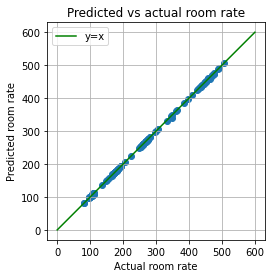

In [11]:
pl.scatter(y=y_pred, x=yte)
pl.title('Predicted vs actual room rate')
pl.ylabel('Predicted room rate')
pl.xlabel('Actual room rate')

lineStart = 0
lineEnd = 600
pl.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'g', label='y=x')
pl.xlim(lineStart, lineEnd)
pl.ylim(lineStart, lineEnd)
pl.axis('square')
pl.grid()
pl.legend(loc='upper left')
pl.rcParams["figure.figsize"] = [6.000, 6.145] # for square plot
# height for scrollable output window below program lines:


# Metrics for prediction versus testing data

In [12]:
print('Mean Squared Error:', metrics.mean_squared_error(yte, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, y_pred)))
print('Normalised Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yte, y_pred))/(float(yte.max()-yte.min())))
#normalise by dividing by range of values in yte

print('R^2:', metrics.r2_score(yte, y_pred))
print('MAE:', metrics.median_absolute_error(yte, y_pred))
#printing various metrics for prediction versus the test data

Mean Squared Error: 1.062148331244758
Root Mean Squared Error: 1.030605807884255
Normalised Root Mean Squared Error: 0.002419210418222755
R^2: 0.9999345612517273
MAE: 0.28979302649935335


<ins>Findings from data</ins>

When comparing y_pred with yte, our model achieved a RMSE of 1.0306, a normalised RMSE of 0.00242, a MAE of 0.290, and a very high R^2 of 0.99993. These suggest an extremely close fit between our predicted data and actual yte data. However, these values appear unusually optimistic and the same performance may not be achieved with test datasets from a different source. We also do not know how the model might perform with data from different geographies or time periods, opening our model's flexibility up to further investigation.

Our regression model has a coefficient of -2.4219 for occupancy rate: as per the law of demand, quantity demanded (occupancy rate) and price (room rate) have an inverse relationship. The coefficient of 2.4643 for room receipt is intuitive as well, as it is calculated by multipling room rate and occupancy rate, where the values of occupancy rate lie within a range of roughly 60-90. Logically, Mid-Tier, Upscale and Luxury rooms have increasingly positive coefficients relative to our baseline type, Economy. We can also observe from the coefficients for Month that rates in February tend to be $34 more expensive as compared to those in January.
